# Feed-forward Network - Basic CNTK Example

A feedforward neural network is an artificial neural network where connections between the units **do not** form a cycle. This is different from recurrent neural networks.

The feedforward neural network was the first and simplest type of artificial neural network devised. In this network, the information moves in only one direction, forward, from the input nodes, through the hidden nodes (if any) and to the output nodes. There are no cycles or loops in the network

<img src="https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif",width=150, height=150>



In [1]:
# Import the relevant components
import numpy as np
import sys
import os
import cntk
from cntk import learning_rates_per_sample, DeviceDescriptor, Trainer, sgd_learner
from cntk import cntk_device, StreamConfiguration, text_format_minibatch_source
#from cntk.ops import input_variable, cross_entropy_with_softmax, combine, classification_error, parameter, sigmoid
from cntk.ops import *

In [2]:
# Specify the target device to be used for computing (this example is showing for CPU usage)
target_device = DeviceDescriptor.cpu_device()    
DeviceDescriptor.set_default_device(target_device)

## Data Generation
In this example, we are going to generate some random data. In this example we will use a uses a 2 dimensional data with 2 classes. The number of green nodes (refer to picture above) in each layer is set to 50 in the example and the number of hidden layers (refer to the number of layers of green nodes) is 2. Fill in the following values:
- input_dim
- num_output_classes
- num_hidden_layers
- hidden_layers_dim

In [3]:
#Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the network
input_dim = 2
num_output_classes = 2
num_hidden_layers = 2
hidden_layers_dim = 50


#### Input and Labels

In this tutorial we are generating synthetic data using `numpy` library. In real world problems, one would put in a reader, that would read a feature matrix (`features`) where each row would represent an obeserved feature set.  Note, the each observation can reside in a higher dimension space and will be represented as a tensor.

For supervised classification, corresponding to each observation (set of features - entries in our row matrix), we associate a label. In our example we have binary classification problem. Hence the labels are 0 or 1. Note the code above supports multi-class classification and thus the `labels` variable has the dimension of *number of samples* $\times$ *number of classes*. In this tutorial, each row shall have only a single entry of 1 indicating where the column index corresponds to the class label.

In [4]:
#Helper function to generate a random data sample
def generate_random_data(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y  

In [5]:
# Create the input variables denoting the features and the label data
mysamplesize = 25
features, labels = generate_random_data(mysamplesize, input_dim, num_output_classes)
input = input_variable((input_dim), np.float32)
label = input_variable((num_output_classes), np.float32)

Let's plot the data to see how the input data looks. 
**Caution**: If the import of `matplotlib.pyplot` fails, please run `conda install matplotlib` which will fix the `pyplot` version dependencies


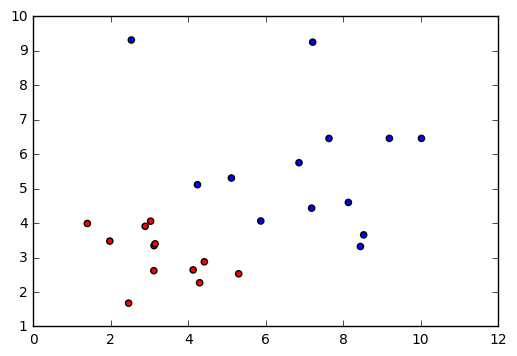

In [6]:
# Plot the data 
import matplotlib.pyplot as plt

#given this is a 2 class 
colors = ['b' if l == 0 else 'r' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.show()

#### Model parameters

A feed forward network requires:
- an **input** variable: This is the equal to the dimension of the data, e.g., if a 2D array with 10 rows and 5 columns are presented, then the input feature dimension will be 50, 

What is the input dimension of your chosen model?

Lets define the feedforward network one step at a time. The first layer takes an input feature vector ($\bf{x}$) with dimensions (`input_dim`) say $m$) and emits the output a.k.a *evidence* (first hidden layer $\bf{z_1}$ with dimension (`hidden_layer_dim`) say $n$). The each feature in the input layer is connected with a node in the output later by the weight which is represented by a matrix $\bf{W}$ with dimensions ($m \times n$). The first step is to compute the evidence for the entire feature set. Note: we use **bold** notations to denote matrix / vectors: 

$$\bf{z_1} = \bf{W} \times \bf{x} + \bf{b}$$ 

where $\bf{b}$ is a bias vector of dimension $n$. 

### Network setup

The `linear_layer` function is pretty straight forward and should be easy to implement. We perform two operations:
0. multiply the weights ($\bf{W}$)  with the features ($\bf{x}$),
1. add the bias term $\bf{b}$.

In [7]:
def linear_layer(input, output_dim):
    input_dim = input.shape()[0]
    weight_param = parameter(shape=(input_dim, output_dim))
    bias_param = parameter(shape=(output_dim))

    t = times(input, weight_param)
    return bias_param + t

The next step is to convert the *evidence* (the output of the linear layer) through a non linear function a.k.a. *activation functions* of your choice that would squash the evidence to activations using a choice of functions ([found here][]). **Sigmoid** or **Tanh** are historically popular. We will use **sigmoid** function in this tutorial. The output of the sigmoid function often is the input to the next layer or the output of the final layer. 
[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

In [8]:
def fully_connected_layer(input, output_dim, nonlinearity):
    p = linear_layer(input, output_dim)
    return nonlinearity(p);

Now that we have created 1 hidden layer, we need to iterate through the layers to create the fully connected classifier. In this function you can see the output of the first layer ($\bf{h_1}$) `h` becomes the input to the next layer.

**Note**: One of the major convinience of CNTK is the ability of the toolkit to automatically caputre recurrent blocks of input. 

This makes the code highly compact and less error prone when stacking multiple larger networks. In this example we have only 2 layers, hence once could concievably write the code as:

>`h1 = fully_connected_layer(input, hidden_layer_dim, nonlinearity)`

>`h2 = fully_connected_layer(h1, hidden_layer_dim, nonlinearity)`

However, this code becomes very quickly very difficult to read and update when the number of layers or blocks (in convolutional or recurrent networks) that we will see later. CNTK provides this programming construct that greatly eases the burden on the programmer. Hence the following construct is very attractive and will be used in many of the subsequent tutorials:

>`h = fully_connected_layer(input, hidden_layer_dim, nonlinearity)`

>`for i in range(1, num_hidden_layers):`
       
>>`    h = fully_connected_layer(h, hidden_layer_dim, nonlinearity)`

In [9]:
# Defines a multilayer feedforward classification model
def fully_connected_classifier_net(input, num_output_classes, hidden_layer_dim, num_hidden_layers, nonlinearity):
    h = fully_connected_layer(input, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = fully_connected_layer(h, hidden_layer_dim, nonlinearity)

    return linear_layer(h, num_output_classes)

In [10]:
# Create the fully connected classfier
netout = fully_connected_classifier_net(input, num_output_classes, hidden_layers_dim, num_hidden_layers, sigmoid)

### Learning model parameters

Now that the network is setup, we would like to learn the parameters $\bf W$ and $\bf b$ for each of the layers in our network. To do so we convert, the computed evidence ($\bf z_final_layer$) into a set of predicted probabilities $\bf y$ using a `softmax` function.

$$ p = softmax(~evidence~) = softmax(~\bf{z_{ final layer}})$$

One can see the `softmax` function as an activation function that maps the accummulated evidences to a probability distribution over the number of classes, in our example 2 (Details of the [softmax function][])

[softmax function]: http://lsstce08:8000/cntk.ops.html#cntk.ops.softmax

## Training
The output of the softmax is a probability of each observation (rows of $\bf x$) belonging to the respective classes. For training the classifer we need to determine what behavior the model needs to mimic. In other words, we want the generated probabilities to be as close as possible to the observed labels. This function is called the *cost* or *loss* fucntion and shows what is the difference between the learnt model vs. that generated by the training set.

[`Cross-entropy`][] is a popular function to measure the loss and has been used actively in information theory. It is defined as:

$$ H(y) = - \sum_j y_j \log (p_j) $$  

where $y$ is our predicted probability from `softmax` function and $y$ represents the ground truth or the label. Understanding the [details][] of this cross-entropy function is highly recommended.

[`cross-entropy`]: http://lsstce08:8000/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[details]: http://colah.github.io/posts/2015-09-Visual-Information/

In [11]:
loss = cross_entropy_with_softmax(netout, label)

#### Evaluation

In order to evaluate the classification, one can compare the output of the network which for each observation emits a vector of evidences (can be converted into probabilities using `softmax` functions) with dimension equal to number of classes.

In [12]:
label_error = classification_error(netout, label)

### Configure the training

Talk about learning rate here

Talk about he learning parameters

Talk about the optimizer

In [13]:
#Initialize the parameters for the trainer
minibatch_size = 25
num_samples_per_sweep = 10000
num_sweeps_to_train_with = 2
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

# Instantiate the trainer object to drive the model training
learning_rate = learning_rates_per_sample(0.02)
trainer = Trainer(netout, loss, label_error, [sgd_learner(netout.owner.parameters(), learning_rate)])

In [33]:
from cntk.utils import get_train_eval_criterion, get_train_loss
# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency):
    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = get_train_loss(trainer)
        eval_error = get_train_eval_criterion(trainer)
        print ("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

Minibatch: 0, Train Loss: 0.1596841049194336, Train Error: 0.04
Minibatch: 50, Train Loss: 0.1773414993286133, Train Error: 0.04
Minibatch: 100, Train Loss: 0.04359692096710205, Train Error: 0.0
Minibatch: 150, Train Loss: 0.08222903251647949, Train Error: 0.0
Minibatch: 200, Train Loss: 0.29387798309326174, Train Error: 0.12
Minibatch: 250, Train Loss: 0.15555402755737305, Train Error: 0.08
Minibatch: 300, Train Loss: 0.06223107814788818, Train Error: 0.0
Minibatch: 350, Train Loss: 0.1815052795410156, Train Error: 0.08
Minibatch: 400, Train Loss: 0.08325569152832031, Train Error: 0.0
Minibatch: 450, Train Loss: 0.23392257690429688, Train Error: 0.04
Minibatch: 500, Train Loss: 0.06672056198120117, Train Error: 0.0
Minibatch: 550, Train Loss: 0.17000217437744142, Train Error: 0.08
Minibatch: 600, Train Loss: 0.1040743637084961, Train Error: 0.04
Minibatch: 650, Train Loss: 0.11035919189453125, Train Error: 0.04
Minibatch: 700, Train Loss: 0.5002112579345703, Train Error: 0.2
Minibatch

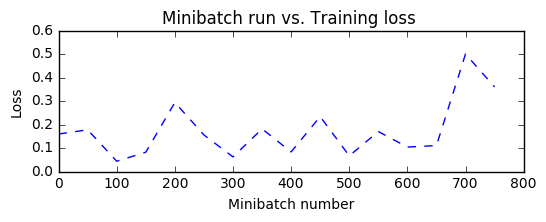

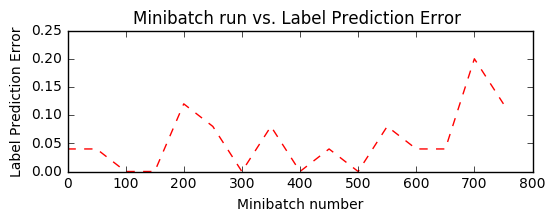

In [41]:
#Run the trainer on and perform model training
training_progress_output_freq = 50

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    features, labels = generate_random_data(minibatch_size, input_dim, num_output_classes)
    # Specify the mapping of input variables in the model to actual minibatch data to be trained with
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq)
    
    if not loss == "NA": 
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

    
#Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

## Evalutaion on test set

Now that we have trained the network. Lets try how the network data on previously unseen data.

In [19]:
#Generate new data
features, labels = generate_random_data(minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})  

In [22]:
val